In [1]:
#Python/Data
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import numpy as np
import h5py as h5

from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

import os
import shutil

#ML
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf

|        |        |        |  Calo Image  |           |           |
|:------:|:------:|:------:|:------------:|:---------:|:---------:|
| Cell E | Cell X | Cell Y | Cell 'Depth' | Layer 1 Z | Layer 2 Z |
|    0   |    1   |    2   |       3      |     4     |     5     |

| Truth   |        |
|:-------:|:------:|
|Truth $E$|Truth $\theta$|

### Load the Data

In [2]:
filename = "2M_hcal_update.hdf5"
#filename = 'rec_pionplus_300ke_1i.hdf5'

label = "Simple_NN_ClusterSum"  #Replace with your own variation!      
path = "./"+label

In [3]:
#os.makedirs(path)

In [4]:
learning_rate = 1e-5
dropout_rate = 0.05
batch_size = 1000
N_Epochs = 400
patience = 20
N_Latent = 128
shuffle_split = True #Turn FALSE for images!
train_shuffle = True #Turn TRUE for images!
Y_scalar = True
loss = 'mse'

In [5]:
h5_file = h5.File(filename,'r')
print(list(h5_file.keys()))
images = h5_file['train_hcal']
truth = h5_file['train_mc']

print(images.shape)
print(truth.shape)
print(images.chunks[0]) #should be = batch_size
print(truth.chunks[0])

['test_hcal', 'test_mc', 'train_hcal', 'train_mc', 'val_hcal', 'val_mc']
(1000000, 4, 1861)
(1000000, 10, 29)
10000
10000


In [6]:
N_Events = 200_000

In [7]:
truth=truth[:N_Events,:,0]
px = truth[:N_Events,3]
py = truth[:N_Events,4]
pz = truth[:N_Events,5]
mass = truth[:N_Events,6]
gen_theta = truth[:N_Events,9]
getStat = truth[:N_Events,2]

p = np.sqrt(px*px + py*py+ pz*pz)
gen_E = np.sqrt(p*p + mass*mass)-mass

In [8]:
hcal_E = images[:N_Events,0]
cluster_sum = np.nansum(hcal_E,axis=-1)

### Check Cuts (Alrady in HDF5 file)

Apply Cuts and get Cluster E Sum

In [9]:
min_theta = 0.0 #5 for HCAL
max_theta = 30.0
min_cluster_E = 100. #MeV

theta_mask = np.logical_and(gen_theta>min_theta, gen_theta<max_theta)
cluster_E_cut = cluster_sum > min_cluster_E

mask = np.logical_and(theta_mask,cluster_E_cut)

In [10]:
print(np.where(cluster_E_cut==False))

(array([12963, 24886]),)


# The Data To Be Used:

In [11]:
clusters = cluster_sum[mask]
truth_E = p[mask]

If Normalization is desired

In [12]:
do_norm = False

if do_norm:
    cluster_mean = np.nanmean(clusters)
    cluster_std = np.nanstd(clusters)
    clusters = (clusters-cluster_mean)/cluster_std

    truth_mean = np.nanmean(truth_E)
    truth_std = np.nanstd(truth_E)
    truth_E = (truth_E-truth_mean)/truth_std
    
    print("DOING NORMALIZATION!!!")

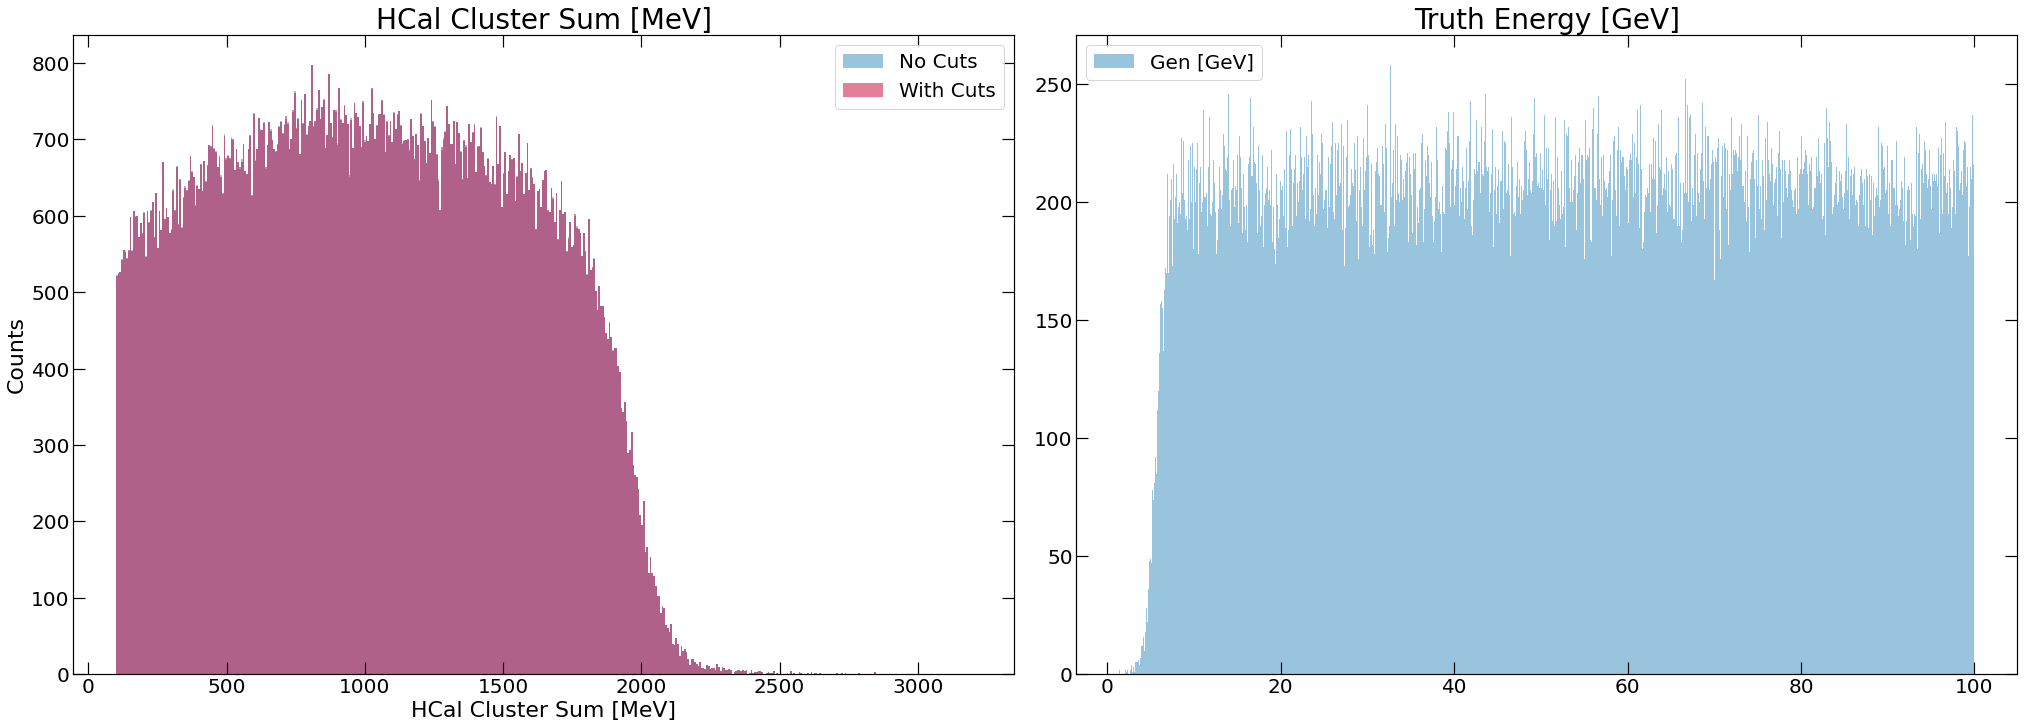

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 10), constrained_layout=True)
axes[0].hist(cluster_sum,bins=500,label="No Cuts",alpha=0.5)
axes[0].hist(clusters,bins=500,label="With Cuts",alpha=0.5)
axes[0].set_title("HCal Cluster Sum [MeV]")
axes[0].set_ylabel("Counts")
axes[0].set_xlabel("HCal Cluster Sum [MeV]")
axes[0].legend()
#axes[1].set_ylim(0,400)

#plt.hist(clusters/1000,bins=1000,alpha=0.5,label="HCal [GeV]")
axes[1].hist(truth_E,bins=1000,alpha=0.5,label="Gen [GeV]")
axes[1].set_title("Truth Energy [GeV]")
axes[1].legend()

### Standard Scalar Energy By Hand

Text(0.5, 1.0, '[HDF5] HCal Sum vs. Generated Energy')

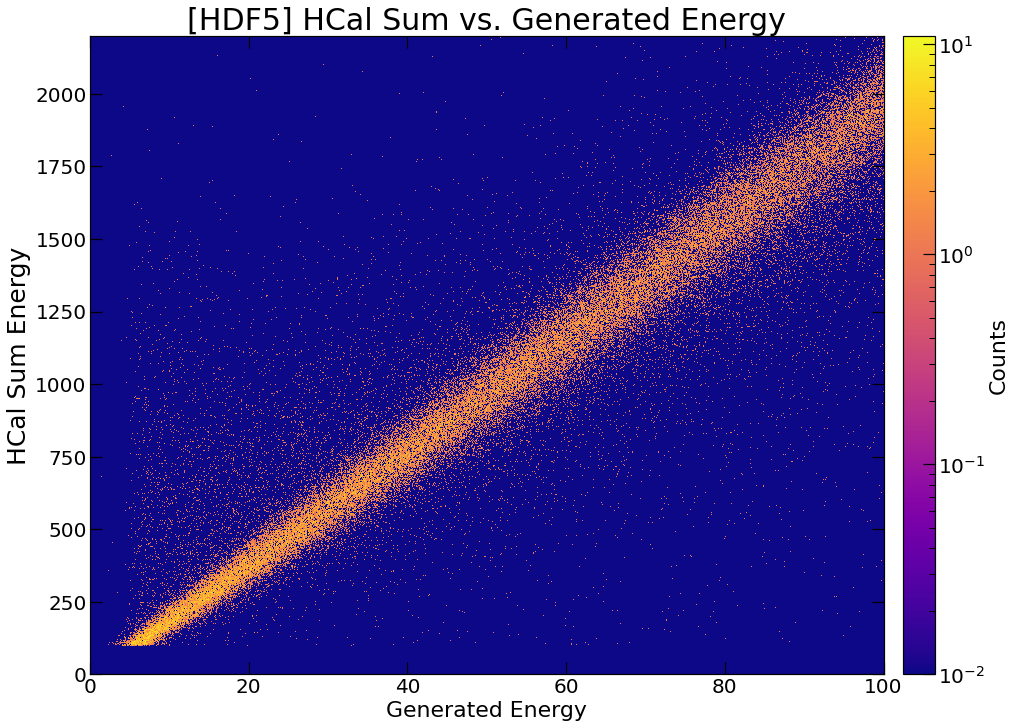

In [14]:
from copy import copy
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))

cluster_edges=np.linspace(0,2200,1201)
truth_edges=np.linspace(0,100,1201)
h, xedges, yedges = np.histogram2d(truth_E, clusters, bins=[truth_edges, cluster_edges])

pcm = axes.pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=1.1e1), rasterized=True)

cb = fig.colorbar(pcm, ax=axes, pad=0)
cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes.set_xlabel("Generated Energy",fontsize=22)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

axes.set_ylabel("HCal Sum Energy",fontsize=25)
axes.set_title("[HDF5] HCal Sum vs. Generated Energy",fontsize=30)

## Use X and Y (semantics for ML Training)

In [15]:
X = clusters
Y = truth_E

In [16]:
(X_train, X_val, X_test,
Y_train, Y_val, Y_test) = data_split(X, Y, val=0.2, test=0.3,shuffle=shuffle_split)

In [17]:
def step_decay(epoch, lr):
    min_rate = 1.01e-7
    N_start = 40
    N_epochs = 20
    
    if epoch >= N_start and lr >= min_rate:
        if (epoch%N_epochs==0):
            return lr * 0.1
    return lr

lr_decay = tf.keras.callbacks.LearningRateScheduler(step_decay,verbose=0)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [19]:
#from tensorflow.keras.layers import Input
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[1]),
    tf.keras.layers.Dense(32, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(32, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(1,activation="linear") # output layer
])

model.compile(loss="mse", optimizer="adam")

the_fit = model.fit(X_train, Y_train, epochs=50,
                    validation_data=(X_val,Y_val),
                    callbacks=[lr_decay,early_stopping],
                    batch_size=batch_size)


Epoch 1/50


2022-11-22 16:27:35.869875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-11-22 16:27:35.869899: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-22 16:27:35.870480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

100/100 [==============================] - 0s 2ms/step - loss: 2212.4214 - val_loss: 89.5094 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 85.3435 - val_loss: 89.0024 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 85.2724 - val_loss: 89.0021 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 85.2693 - val_loss: 88.9582 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 85.2735 - val_loss: 89.0307 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 85.2493 - val_loss: 88.9328 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 85.2156 - val_loss: 88.9010 - lr: 0.0010
Epoch 8/50
100/100 [==============================] - 0s 2ms/step - loss: 85.2141 - val_loss: 88.8828 - lr: 0.0010
Epoch 9/50
100/100 [==============================] - 0s 2ms/step - loss: 85.2060 - val_l

In [20]:
model.save("%s/energy_regression.h5"%(path))
mypreds =  model.predict(X_test,batch_size=400)
#mypreds = mypreds*truth_std + truth_mean
#Y_test  =  Y_test*truth_std + truth_mean
    
np.save("%s/predictions.npy"%(path),mypreds)
np.save("%s/y_test.npy"%(path),Y_test)
np.save("%s/x_test.npy"%(path),X_test)

150/150 [==============================] - 0s 625us/step


___

In [22]:
Y_test = np.load("%s/y_test.npy"%(path))
X_test = np.load("%s/x_test.npy"%(path))
mypreds = np.load("%s/predictions.npy"%(path))

In [23]:
print(path)

./Simple_NN_ClusterSum


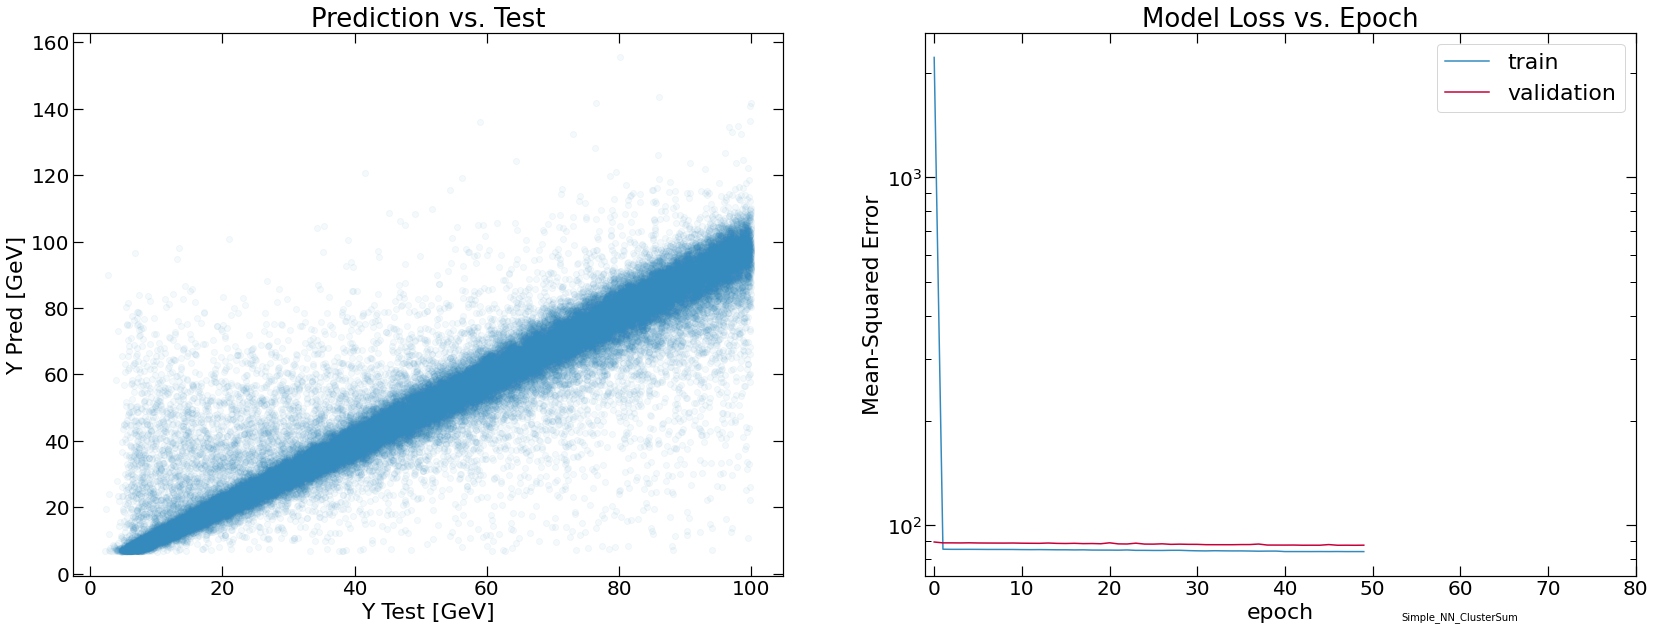

In [24]:
fig = plt.figure(figsize=(28,10))
ax = plt.subplot(1, 2, 1)
plt.scatter(Y_test,mypreds,alpha=0.05)
plt.xlabel("Y Test [GeV]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)

plt.ylabel("Y Pred [GeV]",fontsize=22)
_ = plt.title("Prediction vs. Test",fontsize=26)

ax = plt.subplot(1, 2, 2)
plt.plot(the_fit.history['loss'])
plt.plot(the_fit.history['val_loss'])
plt.title('Model Loss vs. Epoch',fontsize=26)
#plt.text(0.73,0.73,"Step Decayed \n Learning Rate \n {:.1e} to {:.1e}".format(learning_rate,1e-6),
#         transform=ax.transAxes,fontsize=20)
plt.text(0.67,-0.08,label,transform=ax.transAxes,fontsize=10)
plt.ylabel('Mean-Squared Error',fontsize=22)
plt.yscale('log')
plt.xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
plt.xlim([-1,80])
plt.legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("%s/varphi_StepDecay_Prediction_Test.png"%(path))

121


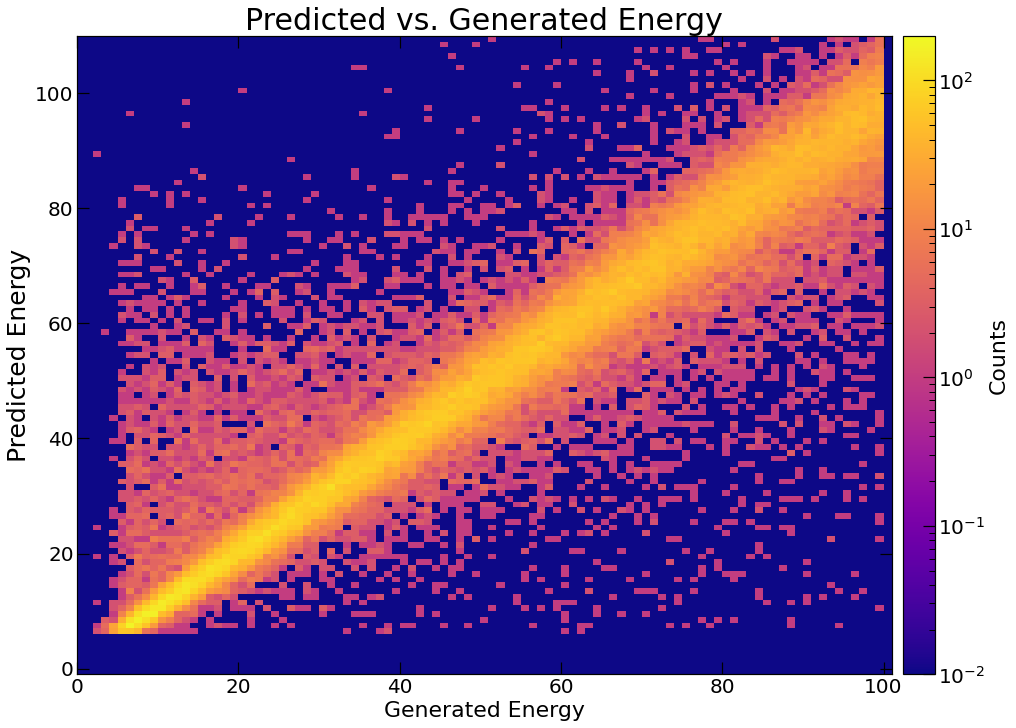

In [25]:
from copy import copy
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(Y_test, mypreds[:,0], bins=[edges, edges])
#xedges=yedges
pcm = axes.pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes, pad=0)
cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes.set_xlabel("Generated Energy",fontsize=22)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(-1,110)
plt.xlim(-0,101)
axes.set_ylabel("Predicted Energy",fontsize=25)
axes.set_title("Predicted vs. Generated Energy",fontsize=30)
plt.savefig("%s/Gen_vs_Pred.pdf"%(path))
print(np.size(yedges))

In [26]:
star_energies = [12,16,20,25,30,50,60,70]
star_res = [0.18, 0.16, 0.15, 0.14, 0.13, 0.098, 0.092, 0.090]

ECCE_res = [0.15,0.127,0.117,0.121,0.106,0.102,0.092,0.098]
ECCE_energies = [10,20,30,40,50,60,80,100]

In [42]:
#Binning
N = 21
E_Max = 100
E_Bins = np.linspace(0,E_Max,N)


#Goal: slices defined by bin of truthE, filled with prediction distributions
indecies = np.digitize(Y_test,E_Bins)-1
max_count = ((np.bincount(indecies).max()))
slices = np.empty((N,max_count))
slices.fill(np.nan)

counter = np.zeros(N,int)
avg_truth = np.zeros(N,float)

pred_over_truth = np.zeros(N,float)

for i in range(len(mypreds)):
    
    #if (Y_test[i] > E_Max): continue
    bin = indecies[i]
    slices[bin][counter[bin]] = mypreds[i] #slices[bin, element inside bin]
    counter[bin]+=1
    avg_truth[bin]+=Y_test[i]
    pred_over_truth[bin] += mypreds[i]/Y_test[i]
    

#Resoluton: stdev(pred)/avg_truth    
avg_truth = avg_truth/counter
stdev_pred = np.nanstd(slices,axis=1)
resolution = stdev_pred/avg_truth

pred_over_truth = pred_over_truth/counter

/tmp/ipykernel_6985/3892076671.py:29: RuntimeWarning: invalid value encountered in true_divide
  avg_truth = avg_truth/counter
/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_6985/3892076671.py:33: RuntimeWarning: invalid value encountered in true_divide
  pred_over_truth = pred_over_truth/counter


/tmp/ipykernel_6985/1443601441.py:13: RuntimeWarning: invalid value encountered in sqrt
  errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred


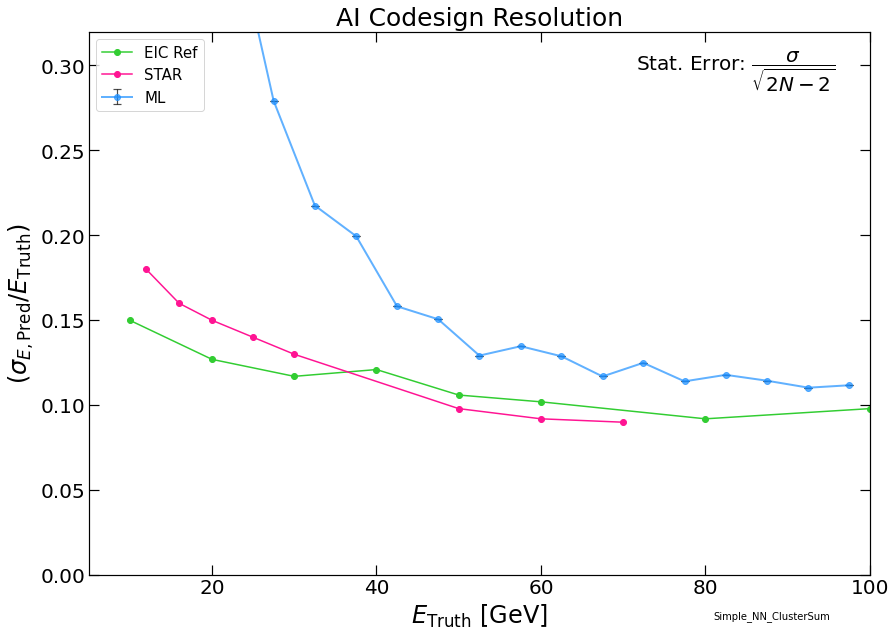

In [43]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution",fontsize=25)
plt.ylabel("$(\sigma_{E,\mathrm{Pred}}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.02,0.4)
plt.ylim(0,2)
plt.ylim(0,.32)
plt.xlim(-0.01,100.01)
plt.xlim(5.0,100)
errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N

plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)
errors = np.zeros(len(errors))
plt.errorbar(avg_truth[first_bin:last_bin],resolution[first_bin:last_bin],yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='dodgerblue',alpha=0.7,label="ML")
_ = plt.text(0.7,0.93,"Stat. Error: $\dfrac{\sigma}{\sqrt{2N-2} } $",transform=ax.transAxes,fontsize=20)

plt.plot(ECCE_energies,ECCE_res,"-o",label = "EIC Ref",color="limegreen")
plt.plot(star_energies,star_res,"-o",label = "STAR",color="deeppink")
plt.legend(fontsize=15,loc="upper left")
plt.savefig("%s/resolution_plot.pdf"%(path))

/tmp/ipykernel_6985/1034262051.py:16: RuntimeWarning: Mean of empty slice
  ax.axvline(x=np.nanmean(slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(slices,axis=-1)[i]))


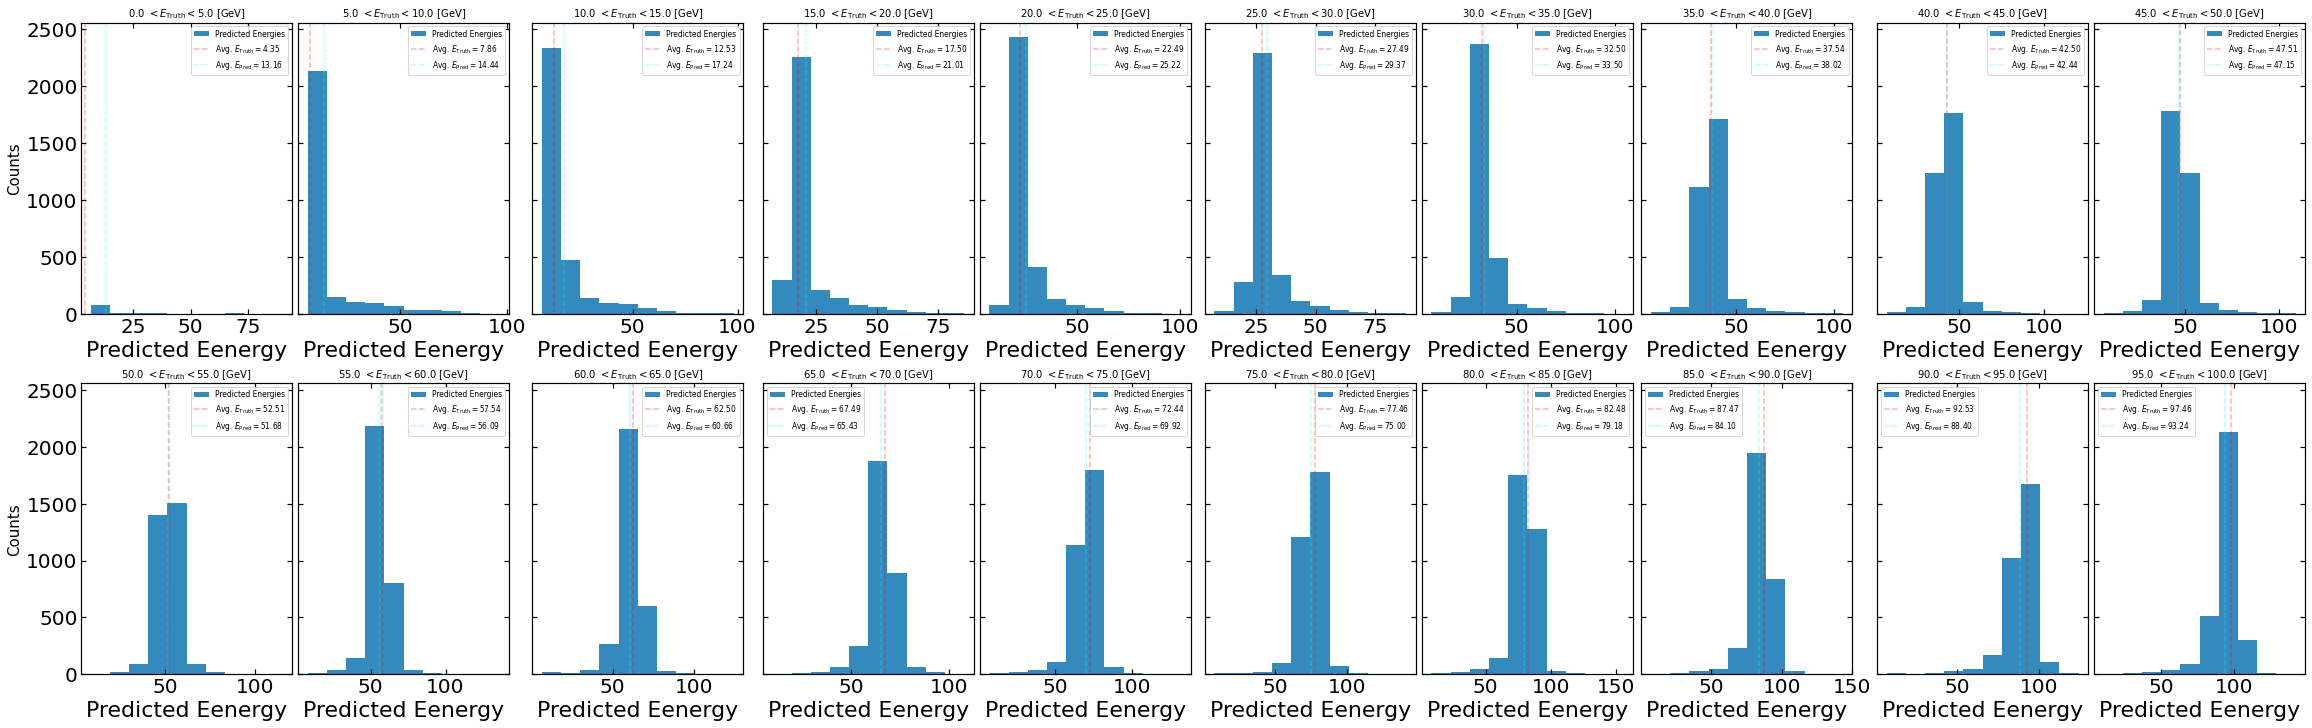

In [44]:
fig,axs = plt.subplots(int(N/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N):
    row = int(i/10)
    col = i%10
    if(row==int(N/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
        
    temp_bin = np.linspace(avg_truth[i]-2.0,avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(slices[i],label="Predicted Energies")
    ax.axvline(x=avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(avg_truth[i]))
    ax.axvline(x=np.nanmean(slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/resolutions_slices.pdf"%(path))

/tmp/ipykernel_6985/3668560432.py:11: RuntimeWarning: invalid value encountered in sqrt
  errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred


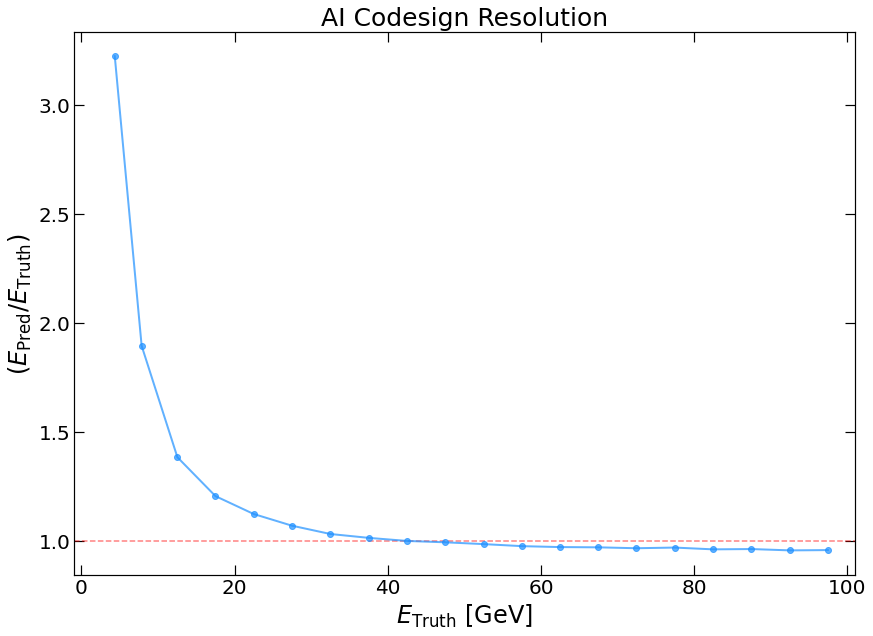

In [45]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution",fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='r', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
#plt.ylim(0.5,1.5)
plt.xlim(-1,101)
errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N
plt.errorbar(avg_truth[first_bin:last_bin],pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='dodgerblue',alpha=0.7)
plt.savefig("%s/scale_plot.pdf"%(path))

17 / 59999 Events [0.028%]


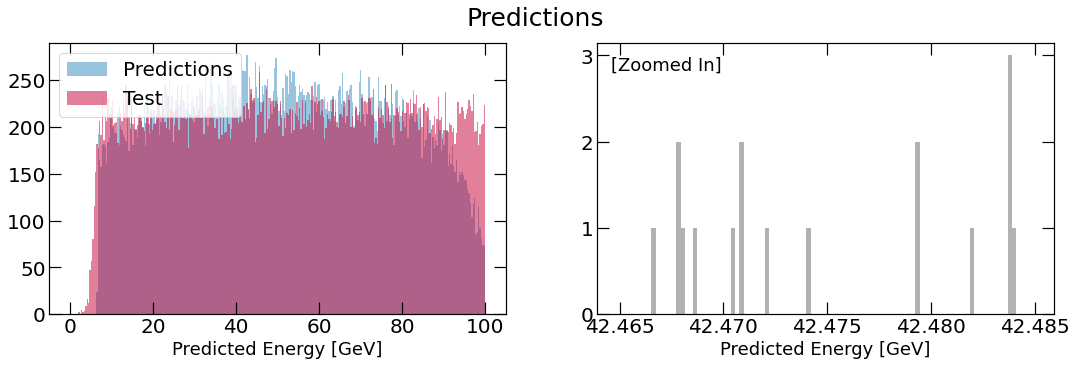

In [46]:
#Find the peak and zoom in
fig = plt.figure(figsize=(18,5))
plt.suptitle("Predictions",fontsize=25)
ax = plt.subplot(1, 2, 1)
plt.xlabel("Predicted Energy [GeV]",fontsize=18)
bins = np.linspace(0,100,300)
freq = plt.hist(mypreds, bins=bins,alpha=0.5,label="Predictions")
test_freq = plt.hist(Y_test,bins=bins,alpha=0.5,label="Test")
ax.legend()

ax = plt.subplot(1, 2, 2)
plt.xlabel("Predicted Energy [GeV]",fontsize=18)
plt.text(0.03,0.9,"[Zoomed In]",transform=ax.transAxes,fontsize=18)
maxbin = np.argmax(freq[0])
zoom = np.linspace(bins[maxbin]-0.01,bins[maxbin]+0.01,100)
mask = np.where(np.logical_and(mypreds>=bins[maxbin]-0.01, mypreds<=bins[maxbin]+0.01))[0]
_ = plt.hist(mypreds[mask],alpha=.3,color="black",bins=zoom)
print("%i / %i Events"%(len(mask),len(mypreds)),"[{:.3%}]".format( (len(mask)/len(mypreds)) ) )